# Library

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

# Generate a true dataset

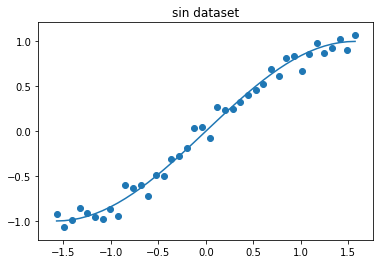

In [2]:
plt.figure()

N = 40 # data number
X_ = np.linspace(-np.pi/2, np.pi/2, N).reshape(N, 1)
y_ = np.sin(X_)

plt.plot(X_, y_)

noise = 0.1 * np.random.randn(N, 1) # output noise for y
y_ += noise

plt.scatter(X_, y_)
plt.title("sin dataset")
plt.show()

# Linear Regression
Linear Regression은 **input $x \in \mathbb{R}^{D}$**의 **output $y \in \mathbb{R}$**에 대한 model을 생각할 때 Linear Regression의 **model f**는 **basis function $\{\phi_{l}: \mathbb{R}^{D} \rightarrow \mathbb{R}\}_{l \in [L]}$**의 linear combination으로 나타난다! **(즉 x에 대한 linearlity를 보장하는 것이 아니다!)** 이를 정리하자면 다음의 수식으로 나타낼 수 있다.
$$
f(x) = \sum_{l=1}^{L}\mathbf{w}_{l}\phi_{l}(x) = \mathbf{w}^{\intercal}\phi(x)
$$

# Make the feature
우리는 이 예제에서 다음의 **basis function**을 이용할 것이다.
$$
\phi_{0}(x) = x^{0} = 1 \\
\phi_{1}(x) = x^{1} = x
$$

In [3]:
n_feature = 2
PHI_ = np.ones([N, 1])
for i in range (1, n_feature):
    PHI_ = np.concatenate((PHI_, np.power(X_, i)), axis=1)

print("PHI_'s shape : ", PHI_.shape)
print("PHI_[:3]\n", PHI_[:3])

# shuffle the dataset
idx = np.random.permutation(N)
shuffle_X_ = X_[idx]
shuffle_PHI_ = PHI_[idx]
shuffle_y_ = y_[idx]

PHI_'s shape :  (40, 2)
PHI_[:3]
 [[ 1.         -1.57079633]
 [ 1.         -1.49024267]
 [ 1.         -1.40968901]]


# Split the dataset

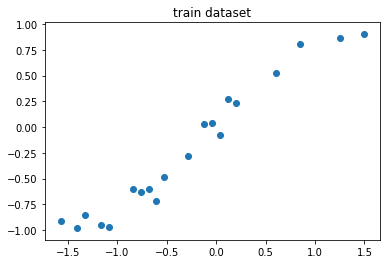

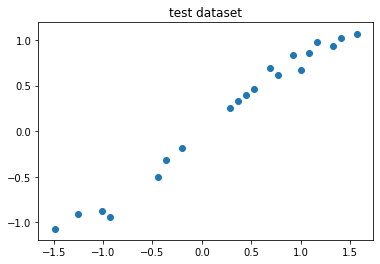

In [4]:
n = 20 # number of train dataset

# train dataset
X_train_ = shuffle_X_[:n]
PHI_train_ = shuffle_PHI_[:n]
y_train_ = shuffle_y_[:n]

# test dataset
X_test_ = shuffle_X_[n:]
PHI_test_ = shuffle_PHI_[n:]
y_test_ = shuffle_y_[n:]

plt.figure()
plt.scatter(X_train_, y_train_)
plt.title("train dataset")
plt.show()

plt.figure()
plt.scatter(X_test_, y_test_)
plt.title("test dataset")
plt.show()

# Solve Linear Regression problem with 4 methods

## 1. Solve Linear Regression problem with closed form expression
Linear Regression문제를 풀 때 가장 먼저 생각해볼 수 있는 방법은 Linear Regression 문제의 Matrix Equation을 풀어서 이에 대한 closed form expression을 구한 다음 식을 계산하여 Optimal Weights를 구해내는 것이다. 이 때 Optimal Weights는 다음과 같이 구할 수 있다.
$$
\mathbf{y} = \Phi\mathbf{w} \\
\Phi^{\intercal}\mathbf{y} = \Phi^{\intercal}\Phi\mathbf{w} \\
\mathbf{w} = (\Phi^{\intercal}\Phi)^{-1}\Phi^{\intercal}\mathbf{y}
$$
### 왜 $w = \Phi^{-1}\mathbf{w}$가 아닐까?
Inverse matrix는 sqaure matrix에서만 정의되기 때문이다.

### 이 방법은 좋은 해를 구해주지만 왜 사용되지 않는 걸까?
역행렬을 구하는 Computational cost는 O(n^3)이기 때문 -> 너무 cost가 크다.
Gauss–Jordan elimination을 기준으로 O(n^3)의 computational cost를 가진다.

In [5]:
w_ = np.linalg.inv(PHI_train_.T @ PHI_train_) @ PHI_train_.T @ y_train_

print("w_ : ", w_)

w_ :  [[-0.00516828]
 [ 0.72848382]]


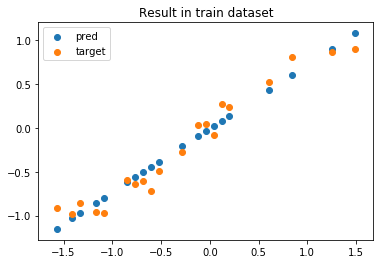

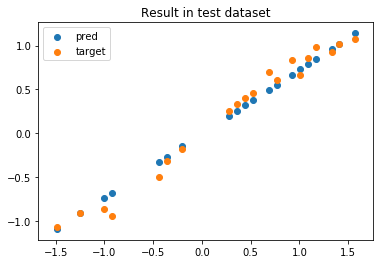

In [6]:
plt.figure()
plt.scatter(X_train_, PHI_train_ @ w_, label="pred")
plt.scatter(X_train_, y_train_, label="target")
plt.title("Result in train dataset")
plt.legend()
plt.show()

plt.figure()
plt.scatter(X_test_, PHI_test_ @ w_, label="pred")
plt.scatter(X_test_, y_test_, label="target")
plt.title("Result in test dataset")
plt.legend()
plt.show()

## 2. Compute w with sklearn library
이 방법도 사실상 close form으로 문제를 푸는 방법이지만 library를 통해 더 쉽게 구현할 수 있음을 확인할 수 있다.

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_, y_train_)

print('b: ', reg.intercept_)
print('W: ', reg.coef_)

b:  [-0.00516828]
W:  [[0.72848382]]


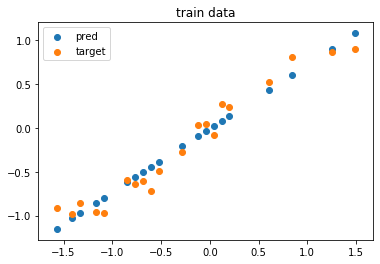

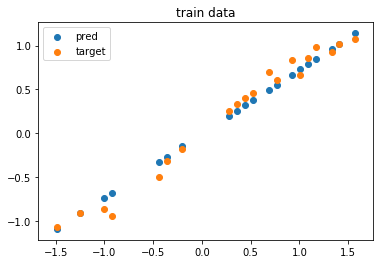

In [8]:
plt.figure()
plt.scatter(X_train_, reg.predict(X_train_), label='pred')
plt.scatter(X_train_, y_train_, label='target')
plt.legend()
plt.title('train data')
plt.show()

plt.figure()
plt.scatter(X_test_, reg.predict(X_test_), label='pred')
plt.scatter(X_test_, y_test_, label='target')
plt.legend()
plt.title('train data')
plt.show()

## 3. Compute w with pytorch library (naive implementation)
이번 방법은 위의 2가지 방법과 달리 Gradient Descent를 기반으로 하는 Linear Regression 방법이다. 우리는 위에서 다음의 Linear Regression식이 다음과 같이 나타난다.
$$
\mathbf{y} = \Phi\mathbf{w} \\
$$
이 때 Gradient Descent Algorithm을 통해서 우리가 찾고자 하는 Optimal Weights를 Iterative한 방법으로 구할 수 있다. 이 때 Gradient의 Update는 다음과 같이 이루어진다.
$$
\mathbf{w}_{new} = \mathbf{w}_{old} - \eta\nabla_{\mathbf{w}}J_{LS}
$$
위의 식에서 $J$는 Loss Function을 나타낸다. 우리가 Linear Regression을 위해서 사용할 Cost Function은 Least Square Loss Function이므로 다음과 같이 나타난다.
$$
J_{LS} = \sum_{n=1}^{N}(y_{n} - f(x_{n}))^{2} = \sum_{n=1}^{N}(y_{n} - \mathbf{w}^{\intercal}\phi(x_{n}))^{2} = ||\mathbf{y} - \Phi \mathbf{w}||_{2}^{2}
$$
이에 대한 w에 대한 Gradient를 구하면 다음과 같이 나타난다.
$$
\begin{align}
\nabla_{w}J_{LS} &= \frac{\partial}{\partial \mathbf{w}}||\mathbf{y} - \Phi \mathbf{w}||_{2}^{2} \\
&= \frac{\partial}{\partial \mathbf{w}}((\mathbf{y} - \Phi\mathbf{w})^{\intercal}(\mathbf{y} - \Phi\mathbf{w})) \\
&= \frac{\partial}{\partial \mathbf{w}}(\mathbf{y}^{\intercal}\mathbf{y} - \mathbf{y}^{\intercal}\Phi\mathbf{w} - \mathbf{w}^{\intercal}\Phi^{\intercal}\mathbf{y} + \mathbf{w}^{\intercal}\Phi^{\intercal}\Phi\mathbf{w}) \\
&= -2\Phi^{\intercal}\mathbf{y} + 2\Phi^{\intercal}\Phi\mathbf{w} \\
&= -2\Phi^{\intercal}(\mathbf{y} - \Phi\mathbf{w}) \\
\end{align}
$$
이제 위의 식을 이용하여 프로그래밍을 진행할 수 있다.

In [9]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# dtype setting
dtype = torch.double

# Tensor setting
PHI_train = torch.tensor(PHI_train_, device=device)
PHI_test = torch.tensor(PHI_test_, device=device)
y_train = torch.tensor(y_train_, device=device)
W = torch.randn([n_feature, 1], device=device, dtype=dtype, requires_grad=False) # We did not use autograd feature in this time

learning_rate = 0.01 # eta means learning rate

print("Training...")

for i in range(20):
    # Calculate prediction and loss
    y_train_pred = PHI_train @ W
    loss = (y_train_pred - y_train).pow(2).sum()
    print("step " + str(i+1) + ": ", loss.item())
    
    # Calculate gradients
    grad_W = - 2 * torch.t(PHI_train) @ (y_train - y_train_pred)
    
    # Update weights using gradient descent algorithm
    W -= learning_rate * grad_W
    
print("Finish Training\n")

print("b: ", W[0].item())
print("w: ", W[1].item())

y_train_pred_ = (PHI_train @ W).cpu().numpy()
y_test_pred_ = (PHI_test @ W).cpu().numpy()

Training...
step 1:  11.191208655652936
step 2:  4.9534838578495926
step 3:  2.5819110684462467
step 4:  1.5361120613933035
step 5:  1.0167225232715706
step 6:  0.7384943337931132
step 7:  0.5831820061612039
step 8:  0.4946860349654704
step 9:  0.4437670253564006
step 10:  0.4143358283969309
step 11:  0.397289010357492
step 12:  0.3874058836387727
step 13:  0.38167349852403853
step 14:  0.37834795158017065
step 15:  0.3764185155510672
step 16:  0.37529903708796786
step 17:  0.3746494919447011
step 18:  0.3742726088174161
step 19:  0.37405393047948493
step 20:  0.37392704684333594
Finish Training

b:  -0.006887826233127676
w:  0.7261205507431251


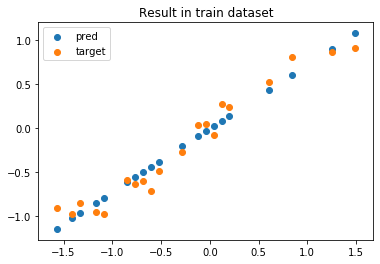

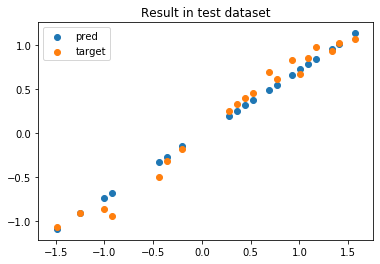

In [10]:
plt.figure()
plt.scatter(X_train_, y_train_pred_, label="pred")
plt.scatter(X_train_, y_train_, label="target")
plt.title("Result in train dataset")
plt.legend()
plt.show()

plt.figure()
plt.scatter(X_test_, y_test_pred_, label="pred")
plt.scatter(X_test_, y_test_, label="target")
plt.title("Result in test dataset")
plt.legend()
plt.show()

## 4. Compute w with pytorch library (general implementation)
앞에서 진행한 방법은 pytorch의 autograd 기능을 사용하지 않고 단순히 우리가 필요한 식을 pytorch로 계산했을 뿐이다. pytorch에서는 autograd라는 편리한 기능을 제공하고 있다. 즉 우리가 설계한 Loss function에 대한 gradient를 pytorch가 라이브러리 단계에서 자동적으로 구해서 이를 사용할 수 있게 해준다. 이를 이용하여 프로그래밍을 진행하면 더 쉽게 모델을 구현할 수 있다.

In [11]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# dtype setting
dtype = torch.double

# Parameter size
D_in = n_feature # We use PHI as input!
D_out = 1

# Tensor setting
PHI_train = torch.tensor(PHI_train_, device=device)
PHI_test = torch.tensor(PHI_test_, device=device)
y_train = torch.tensor(y_train_, device=device)

learning_rate = 0.01 # eta means learning rate

# Construct the model
class LinearModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out)
    def forward(self, x):
        output = self.linear(x)
        return output
    
model = LinearModel(D_in, D_out).to(device, dtype)

# Setting the loss function and optimizer
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training...")

for i in range(20):
    y_train_pred = model(PHI_train)
    
    loss = criterion(y_train_pred, y_train)
    print("step " + str(i+1) + ": ", loss.item())
    
    optimizer.zero_grad() # Set the gradietns to zero
    loss.backward() # Calculate gradients by using backpropagation
    optimizer.step() # Update the weights

print("Finish Training\n")

with torch.no_grad(): # Inform that we did not use the autograd
    y_train_pred_ = model(PHI_train).cpu().detach().numpy()
    y_test_pred_ = model(PHI_test).cpu().detach().numpy()

Training...
step 1:  21.42650334049578
step 2:  4.911319450406827
step 3:  2.637475576604009
step 4:  1.5721254598767653
step 5:  1.0097501751457958
step 6:  0.7113225136104848
step 7:  0.5529259256027859
step 8:  0.46885294850661985
step 9:  0.4242290828927156
step 10:  0.40054383370856644
step 11:  0.38797228658814237
step 12:  0.3812996188962692
step 13:  0.3777579311708277
step 14:  0.3758780905248113
step 15:  0.37488031739280137
step 16:  0.37435072398015173
step 17:  0.37406962883565054
step 18:  0.373920430453694
step 19:  0.3738412396259123
step 20:  0.3737992070842553
Finish Training



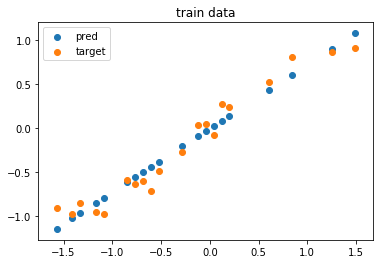

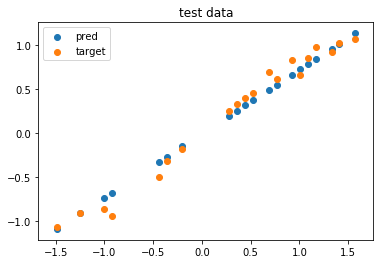

In [12]:
plt.figure()
plt.scatter(X_train_, y_train_pred_, label='pred')
plt.scatter(X_train_, y_train_, label='target')
plt.legend()
plt.title('train data')
plt.show()

plt.figure()
plt.scatter(X_test_, y_test_pred_, label='pred')
plt.scatter(X_test_, y_test_, label='target')
plt.legend()
plt.title('test data')
plt.show()

model의 형태가 단순한 경우 torch.nn.module을 상속하여 class를 만들지 않더라도 **torch.nn.Sequential**을 이용하면 쉽게 model을 구성할 수 있다.

In [13]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# dtype setting
dtype = torch.double

# Parameter size
D_in = n_feature # We use PHI as input!
D_out = 1

# Tensor setting
PHI_train = torch.tensor(PHI_train_, device=device)
PHI_test = torch.tensor(PHI_test_, device=device)
y_train = torch.tensor(y_train_, device=device)

learning_rate = 0.01 # eta means learning rate

# Construct the model    
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)
model.to(device, dtype)

# Setting the loss function and optimizer
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training...")

for i in range(20):
    optimizer.zero_grad() # Set the gradietns to zero
    
    y_train_pred = model(PHI_train)
    
    loss = criterion(y_train_pred, y_train)
    print("step " + str(i+1) + ": ", loss.item())

    loss.backward() # Calculate gradients by using backpropagation
    optimizer.step() # Update the weights

print("Finish Training\n")

with torch.no_grad(): # Inform that we did not use the autograd
    y_train_pred_ = model(PHI_train).cpu().detach().numpy()
    y_test_pred_ = model(PHI_test).cpu().detach().numpy()

Training...
step 1:  5.745477414237476
step 2:  0.5235132937432797
step 3:  0.39434036757893176
step 4:  0.3833953742960676
step 5:  0.37884230472410607
step 6:  0.37645303876399516
step 7:  0.37518547245038497
step 8:  0.3745126924813461
step 9:  0.3741555977219864
step 10:  0.3739660606218134
step 11:  0.3738654589957028
step 12:  0.3738120621294434
step 13:  0.3737837203874986
step 14:  0.37376867728866625
step 15:  0.37376069278217683
step 16:  0.37375645480271613
step 17:  0.3737542053875601
step 18:  0.37375301145337736
step 19:  0.37375237774250863
step 20:  0.37375204138438184
Finish Training



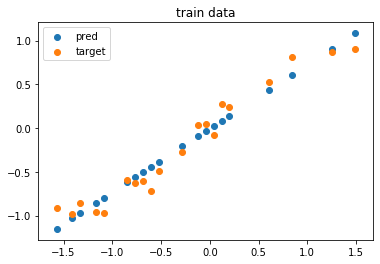

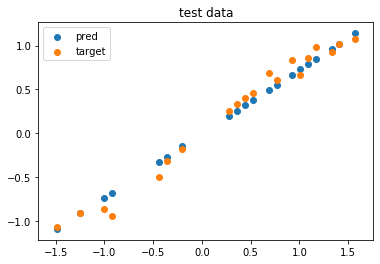

In [14]:
plt.figure()
plt.scatter(X_train_, y_train_pred_, label='pred')
plt.scatter(X_train_, y_train_, label='target')
plt.legend()
plt.title('train data')
plt.show()

plt.figure()
plt.scatter(X_test_, y_test_pred_, label='pred')
plt.scatter(X_test_, y_test_, label='target')
plt.legend()
plt.title('test data')
plt.show()

# Ridge Regression

Linear Regression은 training set에 overfitting 될 수 있다는 문제점을 가지고 있다. 이를 해결하기 위해서 여러가지 regularizaiton 방법들이 적용되고는 한다. 그 중 가장 일반적으로 사용되는 방법이 바로 Ridge Regression 또는 L2 Regularization이다. 이 때 Ridge Regression의 Loss Function은 다음과 같이 나타난다.
$$
J_{Ridge} = ||\mathbf{y} - \Phi \mathbf{w}||_{2}^{2} + \lambda||\mathbf{w}||_{2}^{2}
$$

# Generate new dataset

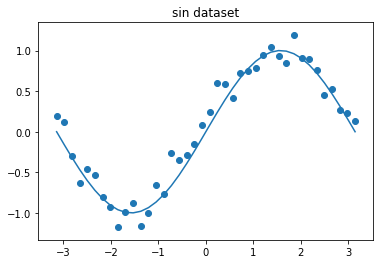

In [15]:
plt.figure()

N = 40 # data number
X_ = np.linspace(-np.pi, np.pi, N).reshape(N, 1)
y_ = np.sin(X_)

plt.plot(X_, y_)

noise = 0.2 * np.random.randn(N, 1) # output noise for y
y_ += noise

plt.scatter(X_, y_)
plt.title("sin dataset")
plt.show()

# Make the feature

In [16]:
n_feature = 10
PHI_ = np.ones([N, 1])
for i in range (1, n_feature):
    PHI_ = np.concatenate((PHI_, np.power(X_, i)), axis=1)

print("PHI_'s shape : ", PHI_.shape)
print("PHI_[:3]\n", PHI_[:3])

# shuffle the dataset
idx = np.random.permutation(N)
shuffle_X_ = X_[idx]
shuffle_PHI_ = PHI_[idx]
shuffle_y_ = y_[idx]

PHI_'s shape :  (40, 10)
PHI_[:3]
 [[ 1.00000000e+00 -3.14159265e+00  9.86960440e+00 -3.10062767e+01
   9.74090910e+01 -3.06019685e+02  9.61389194e+02 -3.02029323e+03
   9.48853102e+03 -2.98090993e+04]
 [ 1.00000000e+00 -2.98048534e+00  8.88329285e+00 -2.64765241e+01
   7.89128919e+01 -2.35198717e+02  7.01006328e+02 -2.08933908e+03
   6.22724450e+03 -1.85602109e+04]
 [ 1.00000000e+00 -2.81937802e+00  7.94889243e+00 -2.24109326e+01
   6.31848909e+01 -1.78142093e+02  5.02249901e+02 -1.41603233e+03
   3.99233044e+03 -1.12558887e+04]]


# Split the dataset

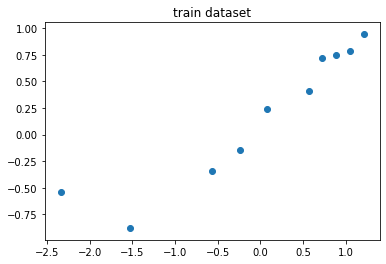

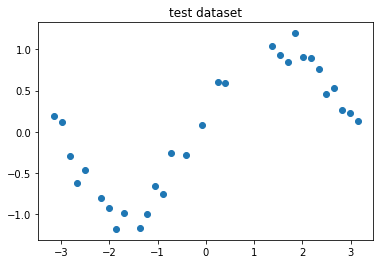

In [17]:
n = 10 # number of train dataset

# train dataset
X_train_ = shuffle_X_[:n]
PHI_train_ = shuffle_PHI_[:n]
y_train_ = shuffle_y_[:n]

# test dataset
X_test_ = shuffle_X_[n:]
PHI_test_ = shuffle_PHI_[n:]
y_test_ = shuffle_y_[n:]

plt.figure()
plt.scatter(X_train_, y_train_)
plt.title("train dataset")
plt.show()

plt.figure()
plt.scatter(X_test_, y_test_)
plt.title("test dataset")
plt.show()

# Ridge Regression with closed form solution

Ridge Regression에서의 w값은 Ridge Regression의 Loss Function을 미분했을 때 0이 되는 지점을 찾음으로써 구할 수 있다. 일단 Ridge Regression의 Loss Function의 Derivative는 다음과 같이 나타난다.
$$
\begin{align}
\frac{\partial}{\partial \mathbf{w}}J_{Ridge} &= \frac{\partial}{\partial \mathbf{w}}(||\mathbf{y} - \Phi \mathbf{w}||_{2}^{2} + \lambda||\mathbf{w}||_{2}^{2}) \\
&= \frac{\partial}{\partial \mathbf{w}}((\mathbf{y} - \Phi\mathbf{w})^{\intercal}(\mathbf{y} - \Phi\mathbf{w}) + \lambda \mathbf{w}^{\intercal}\mathbf{w}) \\
&= \frac{\partial}{\partial \mathbf{w}}(\mathbf{y}^{\intercal}\mathbf{y} - \mathbf{y}^{\intercal}\Phi\mathbf{w} - \mathbf{w}^{\intercal}\Phi^{\intercal}\mathbf{y} + \mathbf{w}^{\intercal}\Phi^{\intercal}\Phi\mathbf{w} + \lambda \mathbf{w}^{\intercal}\mathbf{w}) \\
&= -2\Phi^{\intercal}\mathbf{y} + 2\Phi^{\intercal}\Phi\mathbf{w} + 2 \lambda \mathbf{w}
\end{align}
$$
이 때 $\frac{\partial}{\partial \mathbf{w}}J_{Ridge} = 0$의 조건을 만족해야하므로 다음의 결과를 얻을 수 있다.
$$
-2\Phi^{\intercal}\mathbf{y} + 2\Phi^{\intercal}\Phi\mathbf{w} + 2 \lambda \mathbf{w} = 0 \\
2 (\Phi^{\intercal}\Phi + \lambda I)\mathbf{w} = 2\Phi^{\intercal}\mathbf{y} \\
\mathbf{w}_{Ridge} = (\Phi^{\intercal}\Phi + \lambda I)^{-1} \Phi^{\intercal}\mathbf{y}
$$

In [30]:
lamb = 1e10# 0, 0.5, 1e10 comparision

w_ridge_ = np.linalg.inv(PHI_train_.T @ PHI_train_ + lamb * np.eye(n_feature)) @ PHI_train_.T @ y_train_

print("w_ : ", w_ridge_)

w_ :  [[ 1.94076984e-10]
 [ 6.24158587e-10]
 [-1.77902014e-10]
 [ 1.35296463e-09]
 [-1.72348884e-09]
 [ 4.88667020e-09]
 [-9.43235694e-09]
 [ 2.26666369e-08]
 [-4.97913122e-08]
 [ 1.16193443e-07]]


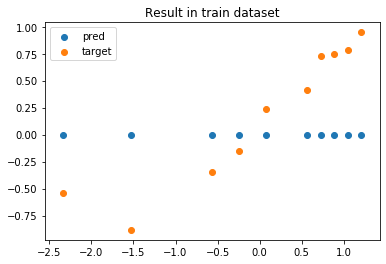

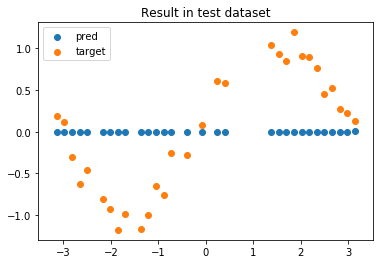

In [31]:
plt.figure()
plt.scatter(X_train_, PHI_train_ @ w_ridge_, label="pred")
plt.scatter(X_train_, y_train_, label="target")
plt.title("Result in train dataset")
plt.legend()
plt.show()

plt.figure()
plt.scatter(X_test_, PHI_test_ @ w_ridge_, label="pred")
plt.scatter(X_test_, y_test_, label="target")
plt.title("Result in test dataset")
plt.legend()
plt.show()

# Ridge Regression with gradient descent algorithm

Pytorch에서 L2 normalization term을 이용하기 위해서는 Optmization function을 사용해야하나 해당 기능을 활용하기보다는 위에서 소개한 방법 중 3번째 방법을 이용하여 구현할 것이다.

이 알고리즘에서 이용하게 될 값은 다음과 같다.
$$
\begin{align}
\frac{\partial}{\partial \mathbf{w}}J_{Ridge} &= -2\Phi^{\intercal}\mathbf{y} + 2\Phi^{\intercal}\Phi\mathbf{w} + 2 \lambda \mathbf{w} \\
&= -2\Phi^{\intercal}(\mathbf{y} - \Phi\mathbf{w}) + 2 \lambda \mathbf{w}
\end{align}
$$